<a href="https://colab.research.google.com/github/alexbatac/VAE-CIFAR10dataset/blob/main/5410_AlexBatac_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ALEX BATAC | N01579147 | Assignment 4

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

Downloading and loading CIFAR 10 data

In [2]:
#Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:14<00:00, 11.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
for X, y in trainloader:
    X = X[:7,:]
    print(X.shape, y.shape)
    break

torch.Size([7, 3, 32, 32]) torch.Size([100])


Create Variational Autoencoder Class

In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Adjusted for CIFAR-10 images (3*32*32 = 3072)
        self.fc1 = nn.Linear(3072, 1024)  # First hidden layer
        self.fc2_mean = nn.Linear(1024, 50)  # Latent mean
        self.fc2_logvar = nn.Linear(1024, 50)  # Latent log variance

        # Decoder layers
        self.fc3 = nn.Linear(50, 1024)
        self.fc4 = nn.Linear(1024, 3072)  # Output size must match input (CIFAR-10)

    def encoder(self, x):
        x = x.view(x.size(0), -1)  # Flatten image to vector (batch_size, 3072)
        h = F.relu(self.fc1(x))
        mu = self.fc2_mean(h)
        log_var = self.fc2_logvar(h)
        return mu, log_var

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        h = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h))
        return out.view(-1, 3, 32, 32)  # Reshape output back to CIFAR-10 format

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterization(mu, logvar)
        predicted = self.decoder(z)
        return predicted, mu, logvar

Create a loss function

In [5]:
def loss_func(reconstructed_image, original_image, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_image, original_image, reduction = 'sum') # BCE Loss for image reconstruction
    DKL = -0.5 * torch.sum(-logvar.exp() - mu.pow(2) + 1 + logvar) # kld loss for reduccing similarities b/w distributions.
    return BCE + DKL # sum of all the losses

Create model instance and set optimizer

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [8]:
model

VAE(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2_mean): Linear(in_features=1024, out_features=50, bias=True)
  (fc2_logvar): Linear(in_features=1024, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=3072, bias=True)
)

Train the model

In [9]:
epochs = 21001

losses = torch.zeros(epochs)

for epoch in range(epochs):
  random_idx = np.random.choice(len(trainloader.dataset), size=32)

  inputs = []
  for idx in random_idx:
    img, _ = trainloader.dataset[idx]
    inputs.append(img)

  inputs = torch.stack(inputs, dim=0).to(device)

  optimizer.zero_grad()

  recon_batch, mu, logvar = model(inputs)
  loss = loss_func(recon_batch, inputs, mu, logvar)
  loss.backward()
  optimizer.step()


  losses[epoch] = loss.item()

  if (epoch % 1000) == 0:
    print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch: 0, Loss: 68861.2734375
Epoch: 1000, Loss: 61879.859375
Epoch: 2000, Loss: 60364.07421875
Epoch: 3000, Loss: 58521.41015625
Epoch: 4000, Loss: 57986.87109375
Epoch: 5000, Loss: 57941.58984375
Epoch: 6000, Loss: 59872.51171875
Epoch: 7000, Loss: 60216.62109375
Epoch: 8000, Loss: 55715.6015625
Epoch: 9000, Loss: 60446.27734375
Epoch: 10000, Loss: 59317.7578125
Epoch: 11000, Loss: 61476.55859375
Epoch: 12000, Loss: 57589.046875
Epoch: 13000, Loss: 58607.31640625
Epoch: 14000, Loss: 60028.1328125
Epoch: 15000, Loss: 57294.7421875
Epoch: 16000, Loss: 56177.59375
Epoch: 17000, Loss: 58927.5234375
Epoch: 18000, Loss: 59488.74609375
Epoch: 19000, Loss: 56467.95703125
Epoch: 20000, Loss: 56404.65625
Epoch: 21000, Loss: 58730.171875


Performance Visualization

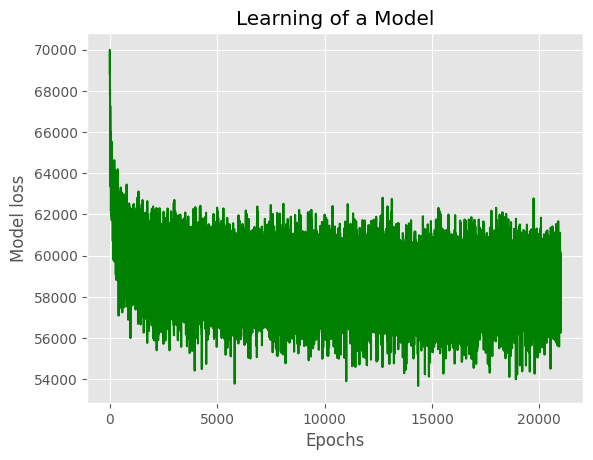

In [10]:
plt.plot(losses, color = 'g', ls = '-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

Smoothing filter

In [11]:
def smooth(x,k=7):
  return np.convolve(x,np.ones(k)/k,mode='same')

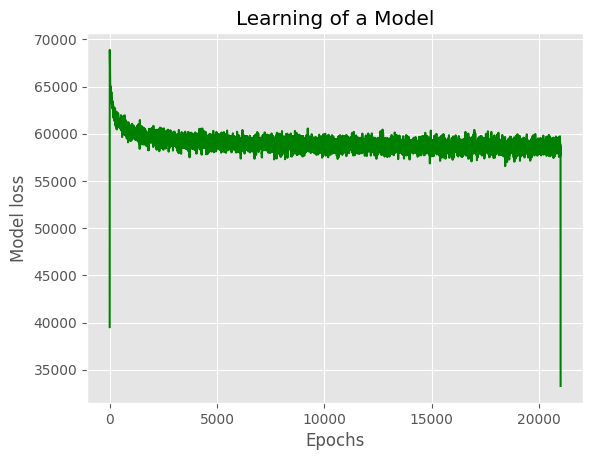

In [12]:
plt.plot(smooth(losses), color = 'g', ls = '-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

Model testing

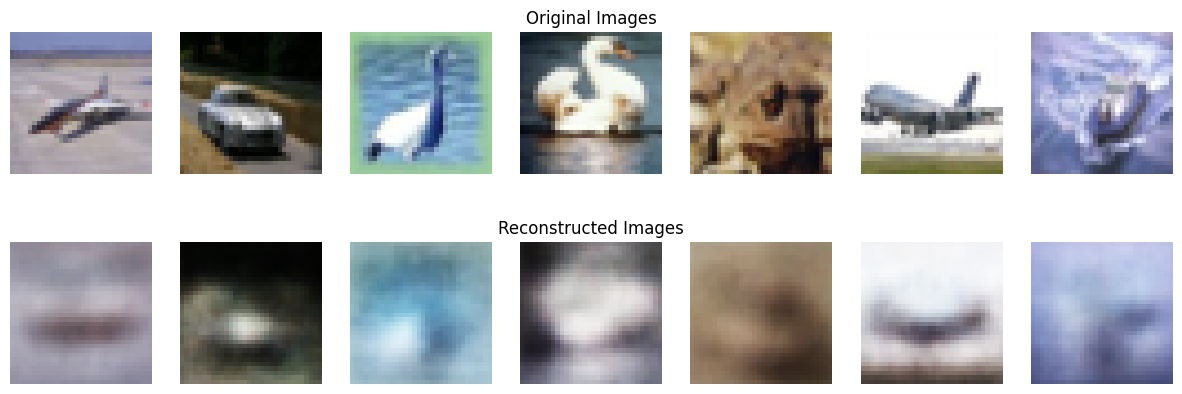

In [20]:
# Get a batch of test images (using the first 7 for visualization)
test_batch, _ = next(iter(trainloader))  # Get a batch from test data
test_batch = test_batch[:7].to(device)  # Take only the first 7 samples

# Pass through VAE
reconstructed, _, _ = model(test_batch)

# Move to CPU for visualization
test_batch = test_batch.cpu().detach()
reconstructed = reconstructed.cpu().detach()

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 7, figsize=(15, 5))

for i in range(7):
    axes[0, i].imshow(test_batch[i].permute(1, 2, 0))
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].permute(1, 2, 0))
    axes[1, i].axis('off')

axes[0, 3].set_title("Original Images", fontsize=12)
axes[1, 3].set_title("Reconstructed Images", fontsize=12)
plt.show()

Visualizing model performance

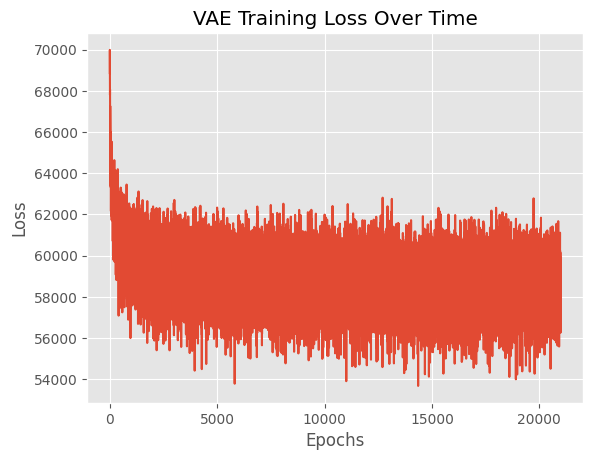

In [21]:
plt.plot(losses.numpy())
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VAE Training Loss Over Time")
plt.show()


Generate 7 Samples from a Gaussian Distribution (Latent Space)

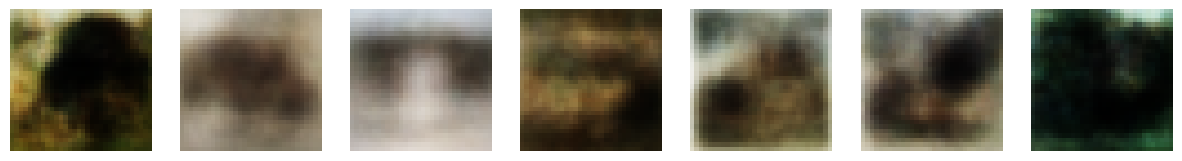

In [23]:
# Generate 7 random samples from standard normal distribution with latent size (50)
z = torch.randn(7, 50).to(device)

# Decode the latent vectors to generate new images
generated_images = model.decoder(z).cpu().detach()

# Plot the generated images
fig, axes = plt.subplots(1, 7, figsize=(15, 5))
for i in range(7):
    img = generated_images[i].permute(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()



Visualize the decoder performance on randomly generated samples

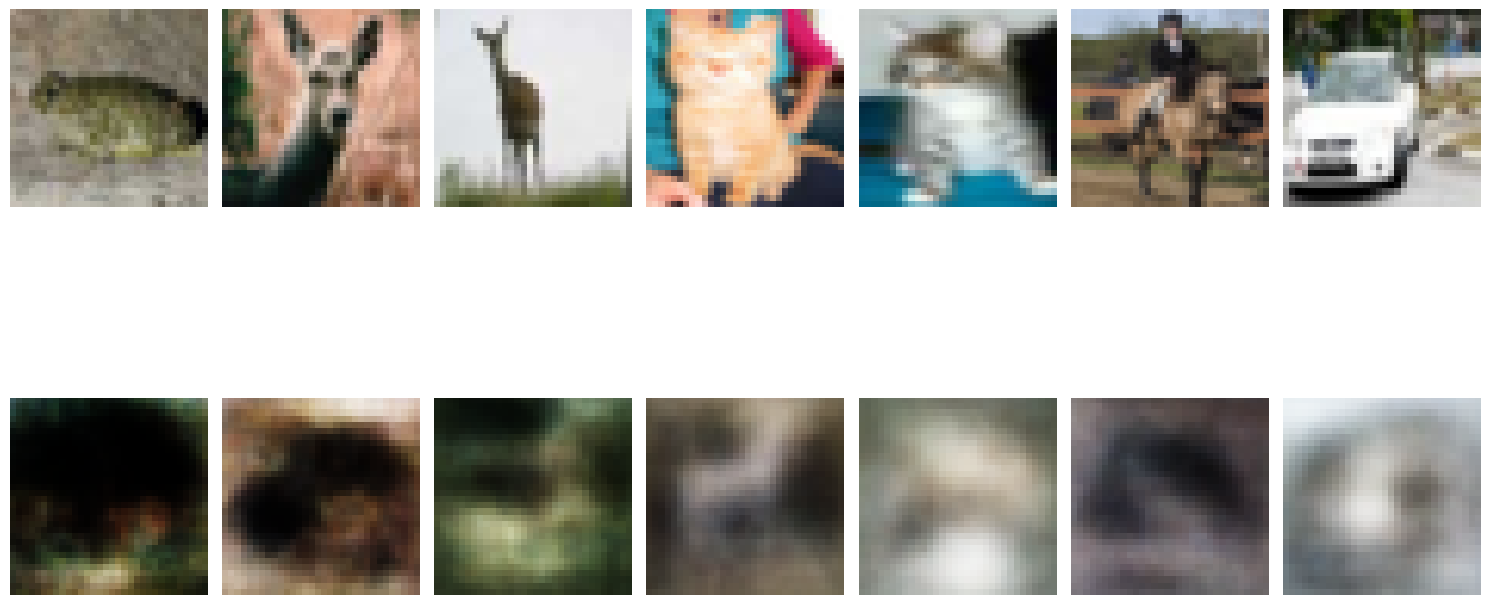

In [26]:
# Generate new samples from the correct latent vector size
random_latent_vectors = torch.randn(7, 50).to(device)  # Change 16 → 50

# Decode the latent vectors to generate new images
generated_images = model.decoder(random_latent_vectors).cpu().detach()

# Sample original images for comparison
random_idx = np.random.choice(len(trainloader.dataset), 7, replace=False)
original_images = []
for idx in random_idx:
    img, _ = trainloader.dataset[idx]  # Extract image (label is ignored)
    original_images.append(img)
original_images = torch.stack(original_images, dim=0).to(device)

# Plot the original and generated images for comparison
fig, axes = plt.subplots(2, 7, figsize=(15, 10))

# Display the original images (top row)
for i in range(7):
    img = original_images[i].cpu().permute(1, 2, 0)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')

# Display the generated images (bottom row)
for i in range(7):
    img = generated_images[i].permute(1, 2, 0)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
